In [1]:
import os,sys,glob,fitsio,subprocess
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import astropy.io
from astropy.io import fits
from astropy.table import Table, Column
import desimodel.io
import desimodel.footprint
import matplotlib.style
import matplotlib as mpl
from desitarget import mtl
from desisim.quickcat import quickcat
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Setting output path for this notebook

In [2]:
# Change this path if you want
outdir= os.path.join(os.environ['SCRATCH'],'desi/priority_tests/')
os.makedirs(outdir, exist_ok=True)
print('Working on {}'.format(outdir))

Working on /global/cscratch1/sd/hiramk/desi/priority_tests/


# Selecting the Year 1 footprint from a surveysim

First we read the exposure.fits file from surveysims path

In [3]:
sim_path = "/project/projectdirs/desi/datachallenge/surveysim2018/weather/035/"
exposures = Table.read(os.path.join(sim_path,'exposures.fits'), hdu=1)
exposures[:5]

MJD,EXPTIME,TILEID,SNR2FRAC,AIRMASS,SEEING,TRANSP,SKY
float64,float32,int32,float32,float32,float32,float32,float32
58819.063888888886,920.0,28576,0.5002821,1.0944833,1.01959,0.9735375,1.0
58819.07523148129,660.0,28576,1.00477,1.0944833,0.9895672,0.9818349,1.0
58819.08425925893,1080.0,28589,0.50211537,1.093335,1.1533324,0.96132696,1.0
58819.09745370316,650.0,28589,1.0113196,1.093335,0.87564546,0.9578879,1.0
58819.10636574006,610.0,28588,0.5042863,1.096941,0.77289426,0.9925911,1.0


Find which tiles are covered during first year

In [4]:
cadence=365
w=np.where(np.int_((exposures['MJD']-exposures['MJD'].min())/cadence)==0)

In [5]:
year1=exposures[w]
year1[:5]

MJD,EXPTIME,TILEID,SNR2FRAC,AIRMASS,SEEING,TRANSP,SKY
float64,float32,int32,float32,float32,float32,float32,float32
58819.063888888886,920.0,28576,0.5002821,1.0944833,1.01959,0.9735375,1.0
58819.07523148129,660.0,28576,1.00477,1.0944833,0.9895672,0.9818349,1.0
58819.08425925893,1080.0,28589,0.50211537,1.093335,1.1533324,0.96132696,1.0
58819.09745370316,650.0,28589,1.0113196,1.093335,0.87564546,0.9578879,1.0
58819.10636574006,610.0,28588,0.5042863,1.096941,0.77289426,0.9925911,1.0


For this test we will use a small area (100 sq.deg), so first we will get those tiles in a 100 sq.deg

In [6]:
alltiles = Table(desimodel.io.load_tiles())
not_bright = alltiles['PROGRAM']!='BRIGHT' # We are only insterested in GREY|DARK targets
tiles= alltiles[not_bright]

# Change this line if needed, if not needed comment, next twolines
ii = (150 < tiles['RA']) & (tiles['RA']<160) & (20<tiles['DEC']) & (tiles['DEC']<30)
tiles=tiles[ii]

print('There are {} tiles in this area.'.format(len(tiles)))

There are 63 tiles in this area.


Now lets see which of those tiles are covered on the first year and save the exposures.fits file for this area. This is needed to run multipass

In [7]:
w=np.isin(tiles['TILEID'],year1['TILEID'])
tiles=tiles[w]
print('There are {} year 1 tiles in this area.'.format(len(tiles)))
tiles.write(outdir+'/reduced_tiles.fits',overwrite=True)

There are 37 year 1 tiles in this area.


In [8]:
pass_num,count= np.unique(tiles['PASS'],return_counts=True)
for p,c in zip(pass_num,count):
    print('Tiles with PASS = {:d}: {:2d}'.format(p,c))

Tiles with PASS = 0: 13
Tiles with PASS = 1: 14
Tiles with PASS = 2:  1
Tiles with PASS = 3:  2
Tiles with PASS = 4:  7


In [9]:
expfolder=os.path.join(outdir,'exposures')
os.makedirs(expfolder,exist_ok=True)
expfile=os.path.join(expfolder,'exposuresY1.fits')
if os.path.exists(expfile):
    print('exposures file already done; skipping')
    year1=Table(fitsio.read(expfile))
else:
    print('Writing exposure file in {}'.format(expfile))
    w=np.isin(year1['TILEID'],tiles['TILEID'])
    year1=year1[w]
    year1.write(expfile)

exposures file already done; skipping


# Reducing a whole footprint mock target selection run to match our footprint

In this step we will select the targets that match the Y1 footprint from a whole footprint mock target selection catalog, these can be found in 
```
/project/projectdirs/desi/users/alxogm/desi/select_mock_targets/onlyqso_all_sky_nospec
```

this is a run of `select_mock_targets` run of only qsos and stars.


In [10]:
def reducefile(file,tiles,outdir='./',nside=16):
    tilepixels=desimodel.footprint.tiles2pix(nside=nside, tiles=tiles)
    print('Getting {} footprint pixels from {}'.format(tilepixels.size,file))
    pixels=Table(fitsio.read(file,columns=['HPXPIXEL']))
    whichtargets=np.isin(pixels['HPXPIXEL'],tilepixels)
    rows=np.where(whichtargets==True)[0]
    filename=os.path.split(file)[-1]
    print('Reducing data')
    reduced = Table(fitsio.read(file,rows=rows))
    name=os.path.join(outdir,filename)
    print(f'Writing reduced file {name}')
    reduced.write(name,overwrite=True)
    print('DONE')
    del reduced
    return rows

In [11]:
mockpath='/global/cfs/projectdirs/desi/mocks/lya_forest/develop/london/smt/nospectra/onlyqso_all_sky_nospec/' # Only QSO catalog
truthfile=os.path.join(mockpath,'truth-dark.fits')
mtlfile=os.path.join(mockpath,'mtl-dark.fits')
targetfile=os.path.join(mockpath,'targets-dark.fits')
skyfile=os.path.join(mockpath,'sky.fits')
fbadir=os.path.join(mockpath,'out_fba')

In [12]:
do_reducefiles = False
do_mtl=False

if not os.path.exists(mtlfile):
    do_mtl=True
    
for filename in ['truth-dark.fits','mtl-dark.fits','sky.fits']:
    if not os.path.exists(os.path.join(outdir,filename)):
        do_reducefiles = True
        break
        
if not do_reducefiles:
    print('Already reduced files; skipping')
else:
    print('Reducing files.')
    sky = reducefile(skyfile,tiles,outdir)
    
    if not do_mtl:
        rows = reducefile(mtlfile,tiles,outdir)
    else:
        print('MTL file does not exist in input path, generating reduced mtl for this run')
        rows = reducefile(targetfile,tiles,outdir)
        targets=fitsio.read(os.path.join(outdir,'targets-dark.fits'))
        mtl = mtl.make_mtl(targets, obscon='DARK')
        mtlname=os.path.join(outdir,'mtl-dark.fits')
        mtl.meta['EXTNAME'] = 'MTL'
        mtl.write(mtlname, overwrite=True, format='fits')
        
    print('Reducing truth file')   
    reduced_truth = Table(fitsio.read(truthfile,rows=rows)) # Truth file doesn't contain a HPXPIXEL column but its aranged the same way as mtl
    reduced_truth.write(os.path.join(outdir,'truth-dark.fits'),overwrite=True)
    #del reduced_truth
    print('DONE')

Already reduced files; skipping


In [13]:
truth_reduced=os.path.join(outdir,'truth-dark.fits')
mtl_reduced=os.path.join(outdir,'mtl-dark.fits')
sky_reduced=os.path.join(outdir,'sky.fits')
tiles_reduced=os.path.join(outdir,'reduced_tiles.fits')
fbadir=os.path.join(outdir,'fba')

In [14]:
#The next step would be to run fiberassign a first time. 

In [15]:
assign_date= "2020-01-01T00:00:00"

In [16]:

# Run fiberassign
cmd = 'fiberassign --overwrite --mtl {mtl} --sky {sky}'
cmd += ' --rundate {}'.format(assign_date)
cmd += ' --footprint {tiles}'
cmd += ' --outdir {out}'
cmd = cmd.format(mtl=mtl_reduced,sky=sky_reduced,tiles=tiles_reduced,out=fbadir)

In [17]:
print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())
    raise ex

RUNNING: fiberassign --overwrite --mtl /global/cscratch1/sd/hiramk/desi/priority_tests/mtl-dark.fits --sky /global/cscratch1/sd/hiramk/desi/priority_tests/sky.fits --rundate 2020-01-01T00:00:00 --footprint /global/cscratch1/sd/hiramk/desi/priority_tests/reduced_tiles.fits --outdir /global/cscratch1/sd/hiramk/desi/priority_tests/fba
INFO: Loaded focalplane for time stamp 2020-01-01 00:00:00
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Target file /global/cscratch1/sd/hiramk/desi/priority_tests/mtl-dark.fits has 297792 rows.  Reading in chunks of 1000000
INFO: Read target file /global/cscratch1/sd/hiramk/desi/priority_tests/mtl-dark.fits:  0.63 seconds (1 calls)
INFO: Target file /global/cscratch1/sd/hiramk/desi/priority_tests/sky.fits has 327680 rows.  Reading in chunks of 1000000
INFO: Read target file /global/cscratch1/sd/hiramk/desi/priority_tests/sky.fits:  3.59 seconds (1 calls)
INFO: Building target tree:  0.17 seconds (1 calls)
INFO: Computing targets available to 

In [18]:
fba_files = np.sort(glob.glob(os.path.join(fbadir,"fiberassign*.fits")))

In [19]:
#Create a first zcatalog as it is done in multipass,  https://github.com/forero/multipass/blob/42c9d13c5ceb9a61c362e2f8117acb697fc29735/run_multilayer.py#L342-L346. 
zcat=quickcat(fba_files,Table.read(mtl_reduced),Table.read(truth_reduced),perfect=True)
zcat

INFO:quickcat.py:585:quickcat: Thu Apr  9 12:56:35 2020 QC Reading 37 tiles
INFO:quickcat.py:629:quickcat: Thu Apr  9 12:56:43 2020 QC Trimming truth to just observed targets
INFO:quickcat.py:636:quickcat: Thu Apr  9 12:56:43 2020 QC Constructing new redshift catalog
INFO:quickcat.py:648:quickcat: Thu Apr  9 12:56:43 2020 QC Adding ZERR and ZWARN
INFO:quickcat.py:666:quickcat: Thu Apr  9 12:56:43 2020 QC Adding NUMOBS column
INFO:quickcat.py:672:quickcat: Thu Apr  9 12:56:43 2020 QC Merging previous zcat
INFO:quickcat.py:719:quickcat: Thu Apr  9 12:56:43 2020 QC done


TARGETID,BRICKNAME,SPECTYPE,Z,ZERR,ZWARN,NUMOBS
int64,str8,str10,float32,float32,int32,int32
288230383395275605,,QSO,2.313405,0.0,0,1
288230383395275606,,QSO,2.5355,0.0,0,1
288230383395275610,,QSO,2.1095347,0.0,0,1
288230383395275617,,QSO,2.3436482,0.0,0,1
288230383395275688,,QSO,2.4378078,0.0,0,1
288230383395275689,,QSO,2.373335,0.0,0,1
288230383395275690,,QSO,2.1967018,0.0,0,1
288230383395275692,,QSO,1.8533612,0.0,0,2
288230383395275693,,QSO,2.7981534,0.0,0,2


In [20]:
old_mtl = Table(fitsio.read(mtl_reduced))
new_mtl = mtl.make_mtl(old_mtl,"DARK|GRAY", zcat=zcat)

INFO:mtl.py:161:make_mtl: 93730 of 297792 targets have priority zero, setting N_obs=0.
INFO:mtl.py:197:make_mtl: Done...t=0.4s


In [21]:
w=~np.isin(new_mtl['TARGETID'],zcat['TARGETID']) #Unobserved targets

In [22]:
pixels=desimodel.footprint.tiles2pix(nside=16, tiles=tiles)
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plt.plot(x,y, '-', color=color, alpha=0.9)

(142.3329515793888, 167.04659105158487, 13.422875676514966, 36.734948165011865)

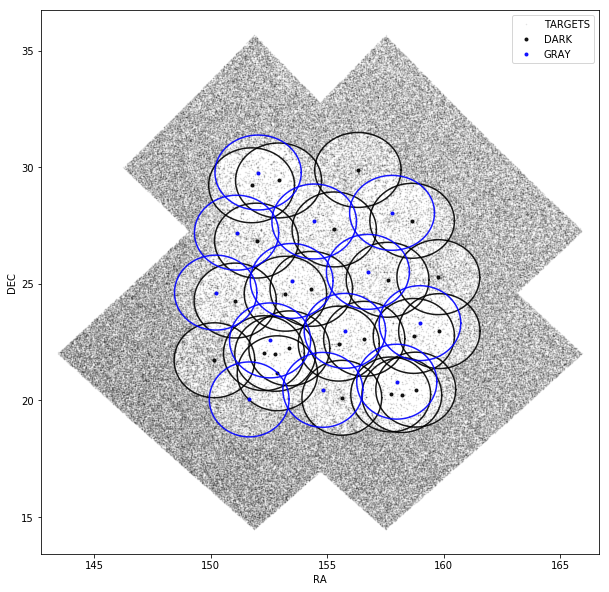

In [25]:
figure(figsize=(10,10))
plt.plot(new_mtl['RA'][w],new_mtl['DEC'][w],'k.',label='TARGETS',markersize=1,alpha=0.1)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY']:
    ii = tiles['PROGRAM'] == program
    plt.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program],label=program, alpha=0.9)
    jj = tiles['PROGRAM'] == program
    for t in tiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])
    plt.legend()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.axis('equal')

## TO DO:
 - You can add some non-zero warnings before saving the  zcatalog
 - You could also add some random error within a reasonable range
 - Save the zcatalog and use it to update the mtl file and run fiberassign again.  zcat.write('./zcat.fits',overwrite=True)
 - Check that the reobservation occurs as expected. 
 - Continue to try to modify the behaviour of reobservation if we provide information from other classifiers... 
 - Repit using an all target type catalog. 